In [ ]:
#改变当前工作目录到谷歌云盘的路径
from google.colab import drive
drive.mount('/content/drive/')
import os
path="/content/drive/My Drive/Colab Notebooks/"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive/


['Untitled5.ipynb',
 'BRAIN-LARGE-scVI.ipynb',
 'BRAIN-SMALL.ipynb',
 'BRAIN-LARGE.ipynb',
 'Untitled (1)',
 'BRAIN-LARGE-prepro.ipynb',
 'learn_scanpy.ipynb',
 'Untitled0.ipynb',
 'scvi_RETINA.ipynb',
 '“preprocessing.ipynb”的副本',
 'Untitled1.ipynb',
 'scvi_CORTEX.ipynb',
 'reproduce_scvi_tutorial.ipynb',
 'scScope.ipynb',
 '“ae_mnist_conv_jax.ipynb”的副本 (1)',
 '“ae_mnist_conv_jax.ipynb”的副本',
 '““ae-dae_on_mnist”的副本”的副本',
 '“ae_dae_on_fashionmnist”的副本',
 'Untitled',
 'cauculate_p.ipynb',
 'Untitled2.ipynb',
 'Untitled3.ipynb',
 'self_ae.ipynb',
 'self_vae.ipynb',
 'data',
 'new_IS.ipynb',
 'FID.ipynb',
 'FID_nb.ipynb',
 'my_dae.ipynb',
 'my_gan.ipynb',
 'my_ae.ipynb',
 'my_sae.ipynb',
 'my_diffusion.ipynb',
 'visualization.ipynb',
 'IS.ipynb',
 'my_vae.ipynb']

In [ ]:
#加载相应包
!pip install memory_profiler
%load_ext memory_profiler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

torch.manual_seed(0)
np.random.seed(0)

#超参数设置
num_epoch = 30
batch_size = 32
lr = 1e-4
N_TEST_IMG = 5
latent_size =16
hidden_size = 128
input_size= output_size = 28*28


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
#下载数据
train_data = datasets.MNIST(
  root = "data",
  train = True,
  transform = transforms.ToTensor(),
  download = True,
)
test_data = datasets.MNIST(
  root = "data",
  train = False,
  transform = transforms.ToTensor(),
  download = True,
)
train_loader = DataLoader(train_data, batch_size, shuffle = True)
test_loader = DataLoader(test_data, batch_size, shuffle = False)

In [ ]:
#定义网络模型，loss，优化器
class Encoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear = torch.nn.Linear(input_size, hidden_size)
        self.mu = torch.nn.Linear(hidden_size, latent_size)
        self.sigma = torch.nn.Linear(hidden_size, latent_size)
    def forward(self, x):# x: bs,input_size
        x = F.relu(self.linear(x)) #-> bs,hidden_size
        mu = self.mu(x) #-> bs,latent_size
        sigma = self.sigma(x)#-> bs,latent_size
        return mu,sigma

class Decoder(torch.nn.Module):
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(latent_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
    def forward(self, x): # x:bs,latent_size
        x = F.relu(self.linear1(x)) #->bs,hidden_size
        x = torch.sigmoid(self.linear2(x)) #->bs,output_size
        return x

class VAE(torch.nn.Module):
    def __init__(self, input_size, output_size, latent_size, hidden_size):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_size, hidden_size, latent_size)
        self.decoder = Decoder(latent_size, hidden_size, output_size)
    def forward(self, x): #x: bs,input_size
        mu,sigma = self.encoder(x) #mu,sigma: bs,latent_size
        eps = torch.randn_like(sigma)  #eps: bs,latent_size
        z = mu + eps*sigma  #z: bs,latent_size
        re_x = self.decoder(z) # re_x: bs,output_size
        return re_x,mu,sigma
#交叉熵
loss_BCE = torch.nn.BCELoss(reduction = 'sum')
#均方误差
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
#KL散度，衡量正态分布(mu,sigma)与正态分布(0,1)的差异
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)

model = VAE(input_size,output_size,latent_size,hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr = lr)

In [ ]:
#训练
%%memit
model.train()
for epoch in range(num_epoch):
  for step, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device).view(-1, input_size), labels.to(device)
    re_images, mu, sigma = model(images)

    loss_re = loss_BCE(re_images, images)
    loss_norm = loss_KLD(mu, sigma)
    loss = loss_re + loss_norm

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  print("Epoch [{}/{}], Loss: {:.4f}".format(epoch+1, num_epoch, loss.item()))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/30], Loss: 6488.1436
Epoch [2/30], Loss: 4967.7622
Epoch [3/30], Loss: 4481.7422
Epoch [4/30], Loss: 4373.8521
Epoch [5/30], Loss: 4363.7744
Epoch [6/30], Loss: 4107.1274
Epoch [7/30], Loss: 3825.1487
Epoch [8/30], Loss: 3853.5615
Epoch [9/30], Loss: 4100.5312
Epoch [10/30], Loss: 3748.1553
Epoch [11/30], Loss: 3992.6086
Epoch [12/30], Loss: 3970.0718
Epoch [13/30], Loss: 3874.4211
Epoch [14/30], Loss: 3526.6140
Epoch [15/30], Loss: 3476.9980
Epoch [16/30], Loss: 4002.0300
Epoch [17/30], Loss: 3876.7993
Epoch [18/30], Loss: 3680.8833
Epoch [19/30], Loss: 3700.0220
Epoch [20/30], Loss: 3572.3950
Epoch [21/30], Loss: 3888.9006
Epoch [22/30], Loss: 3740.0898
Epoch [23/30], Loss: 3750.9519
Epoch [24/30], Loss: 3742.0942
Epoch [25/30], Loss: 3693.9734
Epoch [26/30], Loss: 3570.8987
Epoch [27/30], Loss: 3744.3894
Epoch [28/30], Loss: 3742.5396
Epoch [29/30], Loss: 3641.6943
Epoch [30/30], Loss: 3366.4543
peak memory: 1015.43 MiB, increment: 244.52 MiB


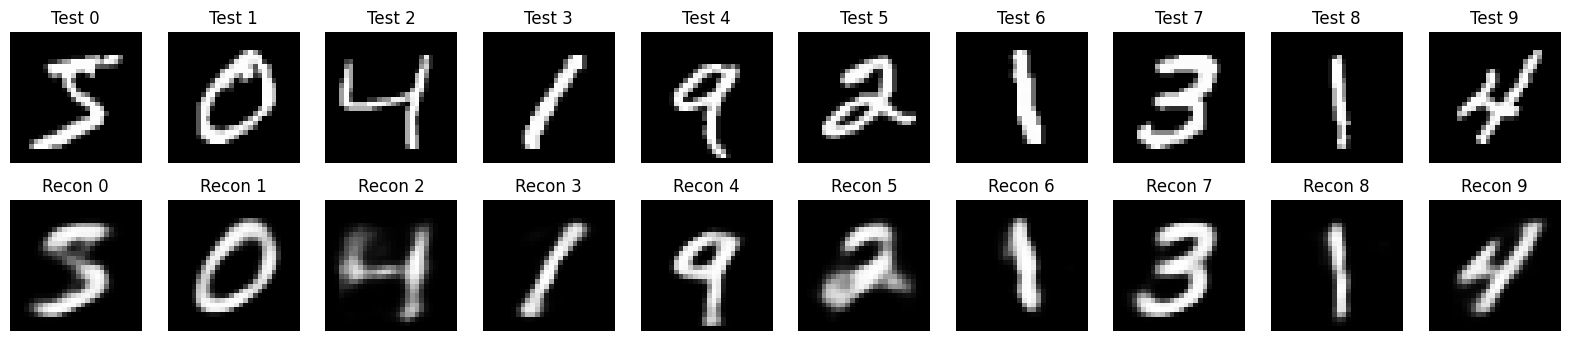

In [ ]:
#比较
fig, axs = plt.subplots(2, 10, figsize=(20, 4))  # 2 行 10 列

for i in range(10):
    test_data = (train_data.data[i].view(-1, 28*28).type(torch.FloatTensor)/255).to(device)
    result,_,_ = model(test_data)
    result = result.view(28, 28).detach().cpu().numpy()


    axs[0, i].imshow(train_data.data[i].cpu().numpy(), cmap='gray')
    axs[0, i].set_title('Test {}'.format(i))
    axs[0, i].axis('off')

    axs[1, i].imshow(result, cmap='gray')
    axs[1, i].set_title('Recon {}'.format(i))
    axs[1, i].axis('off')

plt.show()

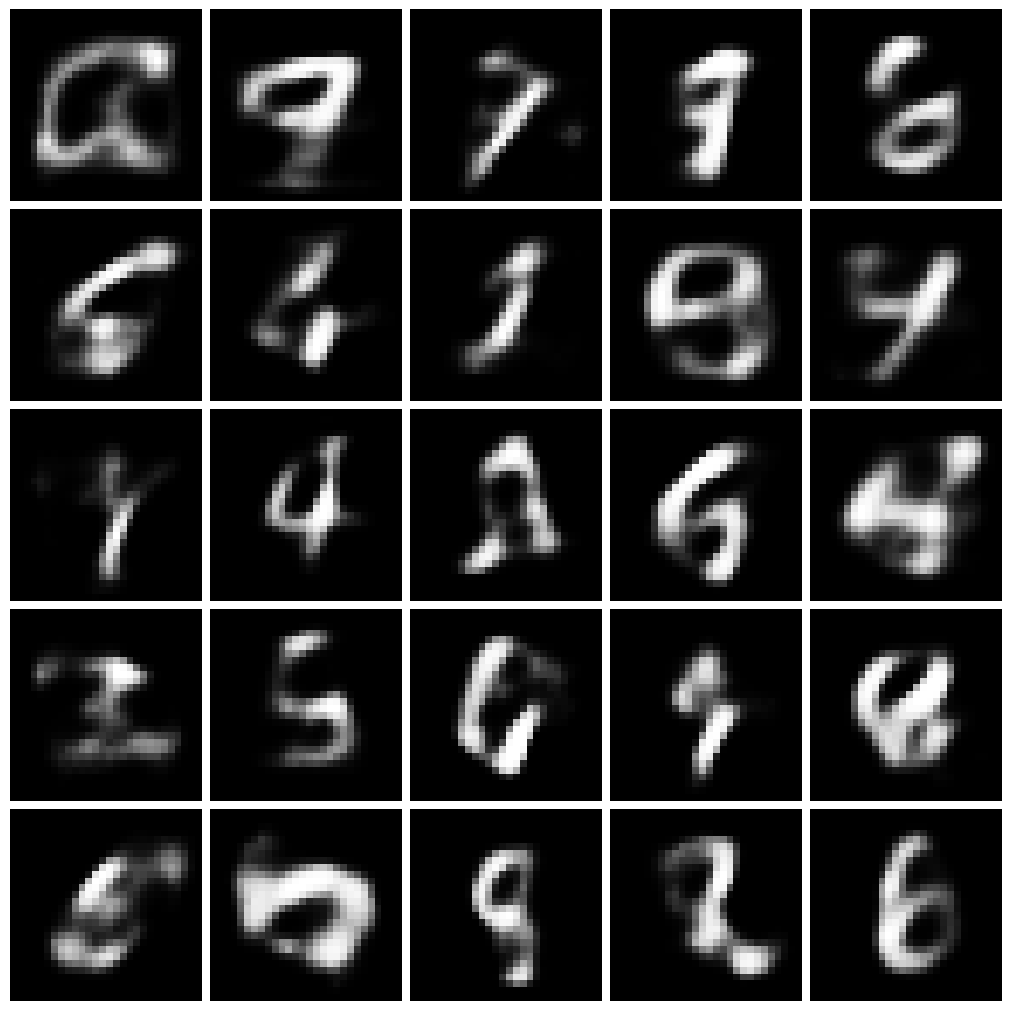

In [ ]:
#生成
num_samples = 25

latent_vectors = torch.randn(num_samples, latent_size).to(device)

with torch.no_grad():
    generated_images = model.decoder(latent_vectors).cpu()

    generated_images = generated_images.view(num_samples, 1, 28, 28)

# DDPM生成MNIST新数据图片
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
gs = fig.add_gridspec(5, 5)

imgs = generated_images.reshape(5, 5, 28, 28).to('cpu')
for n_row in range(5):
    for n_col in range(5):
        f_ax = fig.add_subplot(gs[n_row, n_col])
        f_ax.imshow((imgs[n_row, n_col]), cmap="gray")
        f_ax.axis("off")


In [ ]:
#下载生成数据
import os
from PIL import Image
import torch

directory = '/content/drive/My Drive/vae_fashionmnist_images/'
if not os.path.exists(directory):
    os.makedirs(directory)

num_samples = 1000

latent_vectors = torch.randn(num_samples, latent_size).to(device)

with torch.no_grad():
    generated_images = model.decoder(latent_vectors).cpu()
    generated_images = generated_images.view(num_samples, 1, 28, 28)

for i, image in enumerate(generated_images):
    image = image.squeeze(0)*255.0

    pil_image = Image.fromarray(image.numpy().astype(np.uint8)).convert('RGB')
    pil_image.save(f'/content/drive/My Drive/vae_fashionmnist_images/image_{i:05d}.png')
